In [1]:
import os
# os.chdir('C:/Users/eddie/Desktop/Prof. Rumi Chunara/alcohol')
os.chdir('/home/centos/Alcohol-on-Twitter')

import pickle
import csv
import json
import sklearn
print(sklearn.__version__)
import pandas as pd
import numpy as np
import sys
from evaluation.metric import computeAccuracy, computeF1Score, computeAUC
# from sklearn.metrics import roc_auc_score

# %load_ext autoreload
# %autoreload
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from scipy.stats import uniform
# %reload_ext pipelines.alcohol.AlcoholPipeline
from pipelines.alcohol import AlcoholPipeline
from pipelines.ecig import ECigPipeline

import matplotlib.pyplot as plt

0.21.3


Even the coefficients seem good, we still got 201606 out of 278884 the classifier said was positive (e-cig relevant), which is not good. How about we include some negative sample?

In [2]:
def checkECigaretteInLine(line):
    lineInJson = json.loads(line)
    textInLine = lineInJson["text"]
    lowercaseLine = textInLine.lower()

    # Category keyword
    synonym_ecig = ['electronic-cigarette', 'electronic cigarette', 'electronic cig', ' e-cig', ' ecig', ' e cig', 'e-cigarette', 'ecigarette', ' e cigarette', 'e-juice', ' ejuice', ' e juice', 'e-liquid', ' eliquid', ' e liquid', 'e-smoke', 'esmoke', ' e smoke', 'vape', 'vaper', 'vaping', 'vape-juice',
                    'vape-liquid', ' vapor', 'vaporizer', 'boxmod', 'cloud chaser', 'cloudchaser', 'smoke assist', 'ehookah', 'e-hookah', ' e hookah', 'stillblowingsmoke', 'still blowing smoke', 'cherry tip cigarillo', '#e-cig', '#ecig', '#e cigar', '#ejuice', '#e juice', '#eliquid', '#e liquid', '#vapor', '#ehookah', '#e hookah']
    brand_ecig = ['juul', 'vaporfi', 'vype pebble', 'v2 cig', 'v2cigs', 'v2 cigs', 'halocigs', ' njoy', 'markten', 'vuse', 'tryst', 'atomizer', 'cartomizer', 'south beach smoke', 'eversmoke', 'joye510', 'joye 510', 'joyetech', 'logicecig', 'smartsmoker', ' mistic', 'smokestiks', '21st century smoke', 'logic black label',
                  ' fin ', ' finiti', 'nicotek', 'cigirex', 'ciga&blu', 'cig&blu', 'logic&cig', 'e-swisher', 'e swisher', 'eswisher', 'ezsmoker', 'ez&cig', 'green smoke', 'cigalectric', 'xhale o2', 'xhaleo2', 'cig2o', 'green smart living', 'greensmartliving', 'krave', 'swisher blk', 'grimmgreen', '#njoy', '#fin ', '#finiti']
    policy_ecig = ['sb140', 'sb 140', 'sb24', 'sb 24']
    cessation_ecig = ['notblowingsmoke', 'not blowing smoke',
                      'tobaccofreekids', 'notareplacement']

    # test for synonym
    for keyword in synonym_ecig:
        #         print(keyword)
        if '&' not in keyword and keyword in lowercaseLine:
            return True
        elif '&' in keyword:
            k1, k2 = keyword.split('&')
            if k1 in lowercaseLine and k2 in lowercaseLine:
                return True

            # synonym_ecig_list.append(line)
            # flagHit = True
            # break

    # test for brand
    for keyword in brand_ecig:
        if keyword in lowercaseLine:
            return True
            # brand_ecig_list.append(line)
            # flagHit = True
            # break

    # test for policy
    for keyword in policy_ecig:
        if keyword in lowercaseLine:
            return True
            # policy_ecig_list.append(line)
            # flagHit = True
            # break

    # test for cessation
    for keyword in cessation_ecig:
        if keyword in lowercaseLine:
            return True
            # cessation_ecig_list.append(line)
            # flagHit = True
            # break

    return False

def getPlaceName(jsonLine):
    #     print(jsonLine['place']['name'])
    return jsonLine['place']['name']

def checkLocationInLine(line):
    try:
        tweetInJson = json.loads(line)
        tweetPlace = getPlaceName(tweetInJson)
        tweetPlace_lowercase = tweetPlace.lower()
        if ('san francisco' in tweetPlace_lowercase) or (' SF ' in tweetPlace) or ('sfo' in tweetPlace_lowercase):
            return True
    except:
        return False

def getNotECigaretteLinesFromFile(fileName):
    not_ECigarette_notInSF_Line = set()
    with open(fileName, "r") as f:
        everyLines = f.readlines()
        countOfEachFile = 0
        for line in everyLines:
            # Not in San Francisco & Not include key word
            if not checkLocationInLine(line):
                if not checkECigaretteInLine(line):
                    not_ECigarette_notInSF_Line.add(line)
                    countOfEachFile += 1
            # Each file we only take 400 lines. 24 files in total.
            if countOfEachFile >= 10:
                break
                
    # Write Not E-Cigarette in not SF area data to local file
    not_ECigarette_fileName = '/mnt/volume/result/juliana_NOT_ECigarette_2018_01.json'
    with open(not_ECigarette_fileName, "a", encoding="utf-8") as f:
        for line in not_ECigarette_notInSF_Line:
            f.write(str(line))
            
    

Generate the negative tweets.

In [3]:
# # Generate the negative tweets.

# negative_directoryPath = '/mnt/volume/juliana/data/2018-01-10/'

# # go through each file
# files = os.listdir(negative_directoryPath)
# for file in files:
# #     print(file)
#     file = negative_directoryPath + '/' + file
#     if not os.path.isdir(file) and (os.path.splitext(file)[-1] == ".json"):
# #         print(file)
#         getNotECigaretteLinesFromFile(file)
#         print('finish file: ', file)



Now we read the data to see how many lines in there.

In [4]:
# read the data
# filePath = "C:/Users/eddie/Desktop/Prof. Rumi Chunara/alcohol/data/labeled_figure_eight_csv_1000.csv"
filePath = "/mnt/volume/labeled_data/labeled_figure_eight_csv_1000.csv"
df_labeled = pd.read_csv(filePath)
# df_labeled.is_this_posting_relevant_to_ecigarette[:3]

# Deal with ecig_labels.
ecig_labels = []
# extracting pre-labeled classification
for i in range(0,len(df_labeled.is_this_posting_relevant_to_ecigarette)):
#     print(df.is_this_posting_relevant_to_ecigarette[i])
    if df_labeled.is_this_posting_relevant_to_ecigarette[i] == 'ECIG':
        ecig_labels.append(1)
    elif df_labeled.is_this_posting_relevant_to_ecigarette[i] == 'NOT-ECIG':
        ecig_labels.append(0)
    else:
        print('Should not go to here')
# ecig_labels


# Deal with negative tweets.
not_ECigarette_filePath = '/mnt/volume/result/juliana_NOT_ECigarette_2018_01_250tweetsPerHour.json'
df_not_ECigarette_01 = pd.read_json(not_ECigarette_filePath, lines=True, encoding='utf-8') 

print('We generated %d negative tweets.' % (len(df_not_ECigarette_01)))
label_not_ECigarette = [0]*len(df_not_ECigarette_01)
ecig_labels.extend(label_not_ECigarette)
print('We got %d labels in total, among which %d of them are positive (e-cig relevant)' % (len(ecig_labels), sum(ecig_labels)))

# Combine the two data frame
series_textFromLabeled = df_labeled.realdonaldtrump_foxandfriends_smoke_blowing_up_your_orange_ass
series_textFromGenerated = df_not_ECigarette_01.text
series_combined = series_textFromLabeled.append(series_textFromGenerated, ignore_index=True)
# df_combined = pd.concat(df_labeled.realdonaldtrump_foxandfriends_smoke_blowing_up_your_orange_ass, df_not_ECigarette_01.text)
# len(series_combined)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(series_combined, ecig_labels, test_size=0.2, random_state=26)
print('length of X_train: ', len(X_train))
print('length of X_test: ', len(X_test))
print('length of y_train: ', len(y_train))
print('length of y_test: ', len(y_test))

We generated 5967 negative tweets.
We got 6969 labels in total, among which 571 of them are positive (e-cig relevant)
length of X_train:  5575
length of X_test:  1394
length of y_train:  5575
length of y_test:  1394


In [5]:
# LR
clf_ecig_LR = ECigPipeline().pipeline(LogisticRegression())
clf_ecig_LR.steps

[('tfidf',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.0, max_features=None,
                  min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                  smooth_idf=True, stop_words=None, strip_accents=None,
                  sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, use_idf=True, vocabulary=None)),
 ('clf',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False))]

In [6]:
clf_ecig_LR.fit(X_train, y_train)

/home/centos/anaconda3/envs/yijun/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [7]:
# predict in testing set.
y_ecig_LR = clf_ecig_LR.predict(X_test)
print('Among %d test set tweets, %d should be labeled by 1.' % (len(X_test), sum(y_test)))

# print('length of testing set: ', len(y_alc_initial))
computeAccuracy(y_ecig_LR, y_test)
f1_score_LR = computeF1Score(y_test, y_ecig_LR)
print('F1 Score: ', f1_score_LR)
auc_score_LR = computeAUC(clf_ecig_LR, X_test, y_test, plot=False)
# auc_score = computeAUC(clf_alc_LR_updateParams, X_train, y_train, X_test, y_test, plot=True, plotTitle="Alcohol ROC Curve")
print('alcohol LR AUC: ', auc_score_LR)

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_ecig_LR)

Among 1394 test set tweets, 107 should be labeled by 1.
length of total comps:  1394
76 different item in whole dataset
accuracy: 94.548063%
F1 Score:  0.4492753623188406
alcohol LR AUC:  0.918796157113914


array([[1287,    0],
       [  76,   31]])

Change the threshold.

array([[1285,    2],
       [  41,   66]])

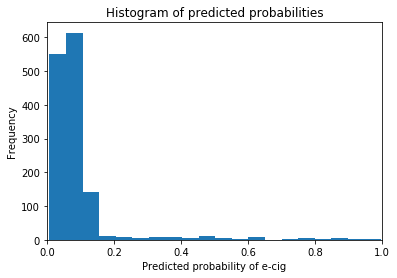

In [8]:
# change the threshold.

prob_ecig_LR = clf_ecig_LR.predict_proba(X_test)[:, 1]
plt.hist(prob_ecig_LR, bins=20)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of e-cig')
plt.ylabel('Frequency')

# tmp = prob_ecig_LR.T
# tmp.shape
# prob_ecig_LR
# prob_ecig_LR.reshape(-1, 1)
from sklearn.preprocessing import binarize
y_ecig_LR_afterThreshold = list(binarize(prob_ecig_LR.reshape(-1, 1), 0.25).reshape(1, -1)[0].astype(int))
y_ecig_LR_afterThreshold
# sum(y_ecig_LR_afterThreshold)

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_ecig_LR_afterThreshold)

Now we run it on San Francisco dataset to see how many of them may related to e-cig.

In [9]:
SF_filePath = '/mnt/volume/result/juliana_allSF_2018_01.json'
df_SF_01 = pd.read_json(SF_filePath, lines=True, encoding='utf-8') 

In [27]:
# Predict with binary label instead of probability, or say the probability is 0.5
print('length of San Francisco data: ', len(df_SF_01))
y_SF_LR = clf_ecig_LR.predict(df_SF_01.text)
print('How many of them the classifier said is positive (e-cig relevant)?: ',sum(y_SF_LR))

length of San Francisco data:  278884
How many of them the classifier said is positive (e-cig relevant)?:  13


Change the threshold of San Francisco data.

In threshold 0.250000, how many of them the classifier said is positive (e-cig relevant)?: 121


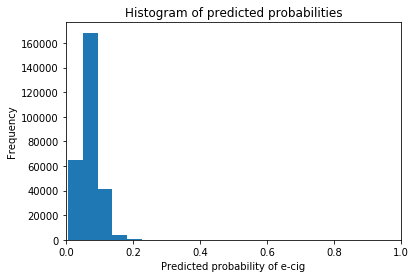

In [13]:
# change the threshold.

prob_SF_LR = clf_ecig_LR.predict_proba(df_SF_01.text)[:, 1]
plt.hist(prob_SF_LR, bins=20)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of e-cig')
plt.ylabel('Frequency')

from sklearn.preprocessing import binarize
threshold_SF = 0.25
y_SF_LR_afterThreshold = list(binarize(prob_SF_LR.reshape(-1, 1), threshold_SF).reshape(1, -1)[0].astype(int))
num_y_SF_LR_afterThreshold = sum(y_SF_LR_afterThreshold)
print('In threshold %f, how many of them the classifier said is positive (e-cig relevant)?: %d'% (threshold_SF, num_y_SF_LR_afterThreshold))



In [14]:
# See the result.
index_in_df_SF = np.where(y_SF_LR_afterThreshold)[0]
for text in df_SF_01.iloc[index_in_df_SF,].text:
    print(text)
    print('-----------')

bitcoins and sneakerheads 😑
-----------
@hsmeIodrama @Harry_Styles my lover
-----------
Golden liquid
#ibuddy #buddyvape #vapepens #vapelife #vapershouts #vapereviews #vapepen #vapeshop #vaping… https://t.co/BhP5GAnMuS
-----------
#bayarea NEW #vape #cannabis users; pay attention... ;)  the higher % thc you go, who cares what flavor you have if… https://t.co/0Rr4heqlZA
-----------
Microaggressions and internalized misogyny
-----------
@SusanNow3 Madoff's companion and roommate.
-----------
Over break someone saw me wearing my Columbia sweatshirt and they asked if I went there and I was like oh nooooooooooooooooooooooooo
-----------
@Michael_Neal and?
-----------
@philmcmichael @ktopenn @BoulderBabyM And facial expression. 😳
-----------
My bro (on the phone): hello? *hits vape*
-----------
@wth_miguell How do you break a vape pen
-----------
@simonjdickie @NeverNotFunny @PFTompkins @SPONTANEANATION A strange and tragic coincidence #DoloresORiordon
-----------
TRPE DANCING TO MY MY MY
--

In [30]:
clf_ecig_LR.steps
LR_ecig = clf_ecig_LR.steps[1][1]
coefficients = LR_ecig.coef_.tolist()[0]
print('length of coefficients: ', len(coefficients))

length of coefficients:  104474


In [31]:
tfidf_ecig = clf_ecig_LR.get_params()['tfidf']
features = tfidf_ecig.get_feature_names()
print('length of features: ', len(features))
type(features)

length of features:  104474


list

In [32]:
featuresAndCoef = {'features':features,'coefficients':coefficients}
df_featuresAndCoef = pd.DataFrame(featuresAndCoef)
df_featuresAndCoef.sort_values(by=['coefficients'], ascending=False)

,features,coefficients
94947,vape,9.198329
52401,juul,8.818644
95428,vaping,4.682583
80084,smoke,2.143773
62581,my juul,2.106060
95369,vapes,2.014276
95525,vapor,1.999584
8827,and,1.786597
71465,pods,1.720725
62154,my,1.687180


Maybe it's because we couldn't find the best threshold. How about we set the threshold ourself?

In [33]:
# predict in testing set.
# prob_ecig_LR = clf_ecig_LR.predict_proba(X_test)
# y_ecig_LR_prob = []




# threshold = 0.3
# for [neg_proba, pos_proba] in prob_ecig_LR:
#     diff = pos_proba - neg_proba
#     if diff >= threshold:
#         y_ecig_LR_prob.append(1)
#     else:
#         y_ecig_LR_prob.append(0)
# auc_score_LR = computeAUC(clf_ecig_LR, X_test, y_test, plot=False)
# print('alcohol LR AUC: ', auc_score_LR)

# print('Among %d test set tweets, %d should be labeled by 1.' % (len(X_test), sum(y_test)))

# # print('length of testing set: ', len(y_alc_initial))
# computeAccuracy(y_ecig_LR, y_test)
# f1_score_LR = computeF1Score(y_test, y_ecig_LR)
# print('F1 Score: ', f1_score_LR)
# auc_score_LR = computeAUC(clf_ecig_LR, X_test, y_test, plot=False)
# # auc_score = computeAUC(clf_alc_LR_updateParams, X_train, y_train, X_test, y_test, plot=True, plotTitle="Alcohol ROC Curve")
# print('alcohol LR AUC: ', auc_score_LR)